# 时间序列

## 参数配置表

### basic config
parser.add_argument('--task_name', type=str, required=True, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
                    
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')

parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')

parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

### data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')

parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')

parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')

parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
                    
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')

parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
                    
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

### forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')

parser.add_argument('--label_len', type=int, default=48, help='start token length')

parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')

parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

### inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

### anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

### model define
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')

parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')

parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')

parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')

parser.add_argument('--c_out', type=int, default=7, help='output size')

parser.add_argument('--d_model', type=int, default=512, help='dimension of model')

parser.add_argument('--n_heads', type=int, default=8, help='num of heads')

parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')

parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')

parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')

parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')

parser.add_argument('--factor', type=int, default=1, help='attn factor')

parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
                    
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')

parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
                    
parser.add_argument('--activation', type=str, default='gelu', help='activation')

parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')

### optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')

parser.add_argument('--itr', type=int, default=1, help='experiments times')

parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')

parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')

parser.add_argument('--patience', type=int, default=3, help='early stopping patience')

parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')

parser.add_argument('--des', type=str, default='test', help='exp description')

parser.add_argument('--loss', type=str, default='MSE', help='loss function')

parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')

parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

### GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')

parser.add_argument('--gpu', type=int, default=0, help='gpu')

parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)

parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

### de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
                    
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

## 数据集选取

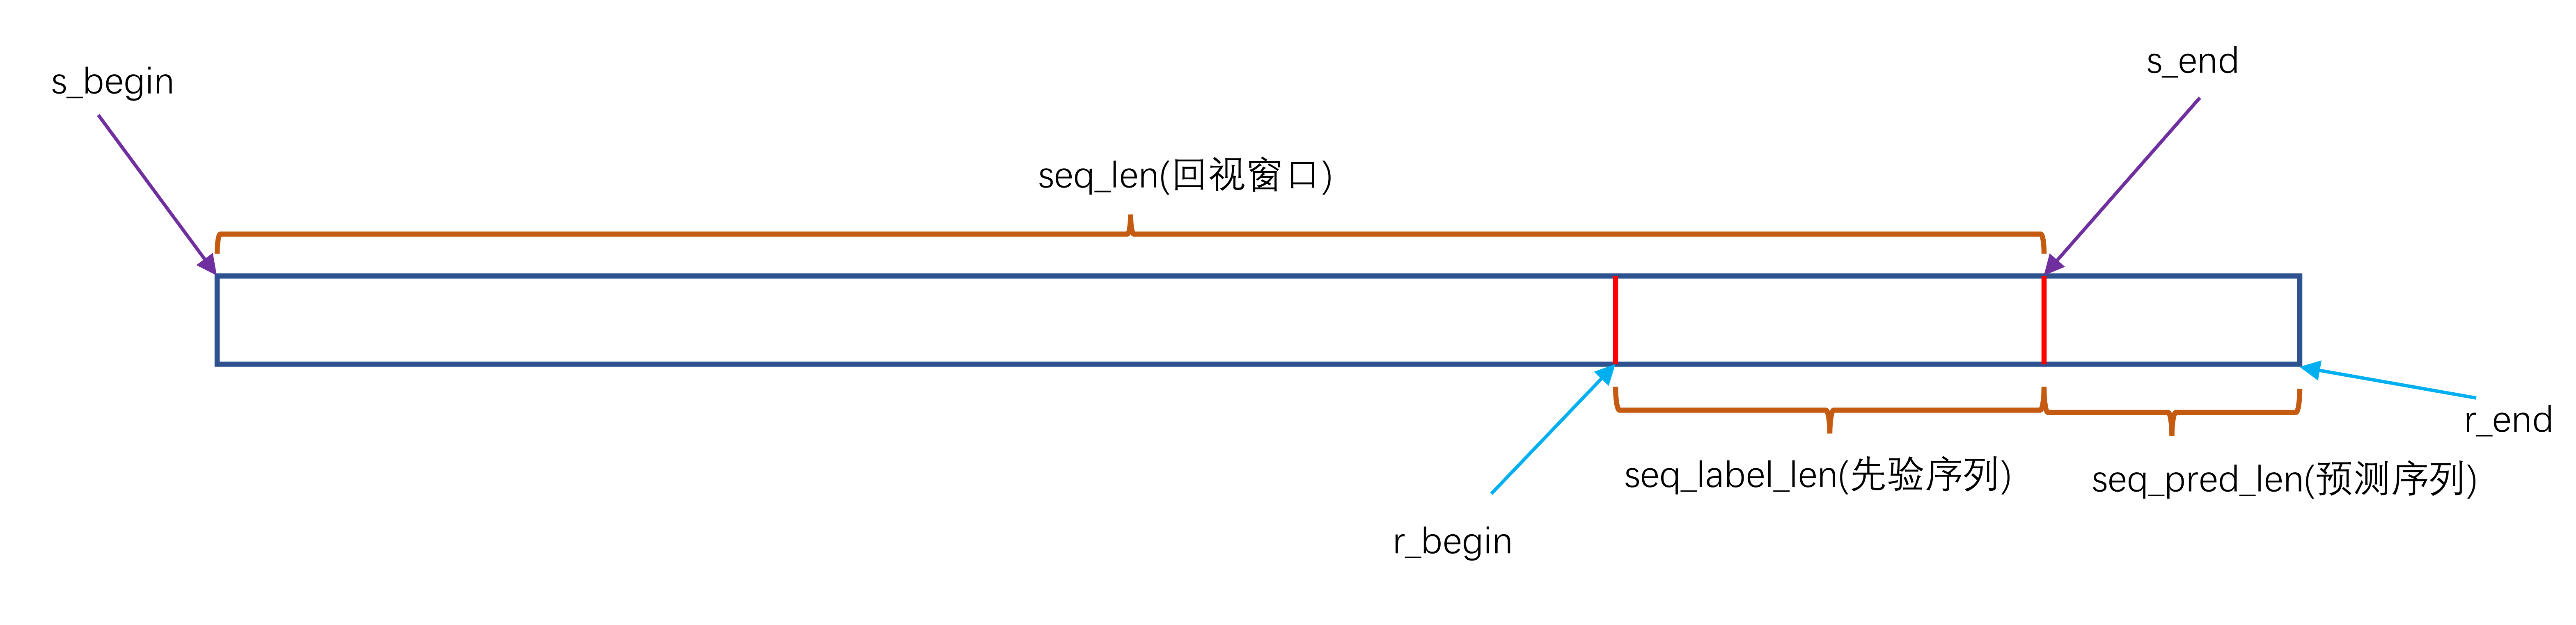

In [1]:
def __getitem__(self, index):
    # 起点
    s_begin = index
    # 终点(起点 + 回视窗口)
    s_end = s_begin + self.seq_len
    # (终点 - 先验序列窗口)
    r_begin = s_end - self.label_len
    # (终点 + 预测序列长度)
    r_end = r_begin + self.label_len + self.pred_len

    # seq_x = [起点,起点 + 回视窗口]
    seq_x = self.data_x[s_begin:s_end]  # 
    # seq_y = [终点 - 先验序列窗口,终点 + 预测序列长度]
    seq_y = self.data_y[r_begin:r_end] # 
    # 取对应时间特征
    seq_x_mark = self.data_stamp[s_begin:s_end]
    seq_y_mark = self.data_stamp[r_begin:r_end]

    return seq_x, seq_y, seq_x_mark, seq_y_mark

## 词向量表示

### 时间特征嵌入

时间特征编码，三种不同的编码方式，三个可选项[timeF, fixed, learned]

- timeF编码：将时间戳拆解为月、日、周、小时、分钟等特征，然后将值缩放为[-0.5,0.5]的小数。

- fixed编码：同样是拆解为各类特征，将其对应的整数用positional encoding的方式进行编码。

- learned编码：同样是拆解为各类特征，将其对应的整数使用Embedding(torch自带的nn.Embedding)进行学习，在训练过程中动态调整。

timeenc = 0 if args.embed!=‘timeF’ else 1，如果timeenc为1，将考虑更多可能的周期信息。timeenc只是Dataloader实现时为了区别不同的时间编码方式做的一个标记，不同的timeenc会加载出不同的timestamp。

#### TemporalEmbedding

TemporalEmbedding的输入要求是(batch_size, seq_len, 6),6表示每个时间戳的月、天、星期（星期一到星期七）、小时以及刻钟数（一刻钟15分钟）、30s。代码中对六个值分别进行了编码，编码方式有两种，一种是FixedEmbedding，它使用位置编码作为embedding的参数，不需要训练参数；另一种就是torch自带的nn.Embedding，参数是可训练的。

更具体的，作者将月、天、星期、小时、刻钟和秒的范围分别限制在了13、32、7、24、4和2。即保证输入每个时间戳的月份数都在0-12，天数都在0-31，星期都在0-6，小时数都在0-23，刻钟数都在0-3，秒数都在0-1。例如2024/04/05/12:13，星期五，输入应该是(4, 5, 5, 13, 0)。注意12:13小时数应该为13，小于等于12:00但大于11:00如11:30才为12。

##### FixedEmbedding

使用位置编码作为embedding的参数，同PositionalEmbedding。

##### nn.Embedding

nn.Embedding 是 PyTorch 中用于查找表的简单查找层，通常用于处理自然语言处理（NLP）任务中的词嵌入。它的主要功能是将词汇表中的每个词映射到一个固定大小的向量表示。

embedding = nn.Embedding(vocab_size, embedding_dim)：创建一个嵌入层，其参数包括词汇表大小和嵌入维度。

#### TimeFeatureEmbedding

TimeFeatureEmbedding的输入为(batch_size, seq_len, d_inp)，d_inp有多达8种选择。具体来说针对时间戳2024/04/05/12:13，以freq='h'为例，其输入应该是(月份、日期、星期、小时)，即(4, 5, 5, 13)，然后针对输入通过函数将所有数据转换到-0.5到0.5之间。

当freq为't'时，输入应该为['month', 'day', 'weekday', 'hour', 'minute']，其他类似。当通过上述函数将四个数转换为-0.5到0.5之间后，再利用TimeFeatureEmbedding中的self.embed = nn.Linear(d_inp, d_model)来将维度从4转换到d_model，因此最终返回的输出大小也为(batch_size, seq_len, d_model)。

### 词嵌入

#### TokenEmbedding

token embedding 层是要将各个词转换成固定维度的向量。使用conv1d的目的是要对序列中的每一个时间点上的数据（也就是token）来做编码。

用conv1d来编码，和直接用Liner(7,512)编码有什么区别？

conv1d中有一个kernel size，相当于在考虑某一个时间点数据的编码时，考虑了一个长度为kernel size的窗口内数据。而直接使用Liner(7,512)，相当于在考虑某一个时间点数据的编码时，只考虑这个时间点的数据，等价于kernel size = 1。

![conv1d和liner示意图](../images/p42.png)
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline">conv1d和liner示意图</center> 

## 掩码

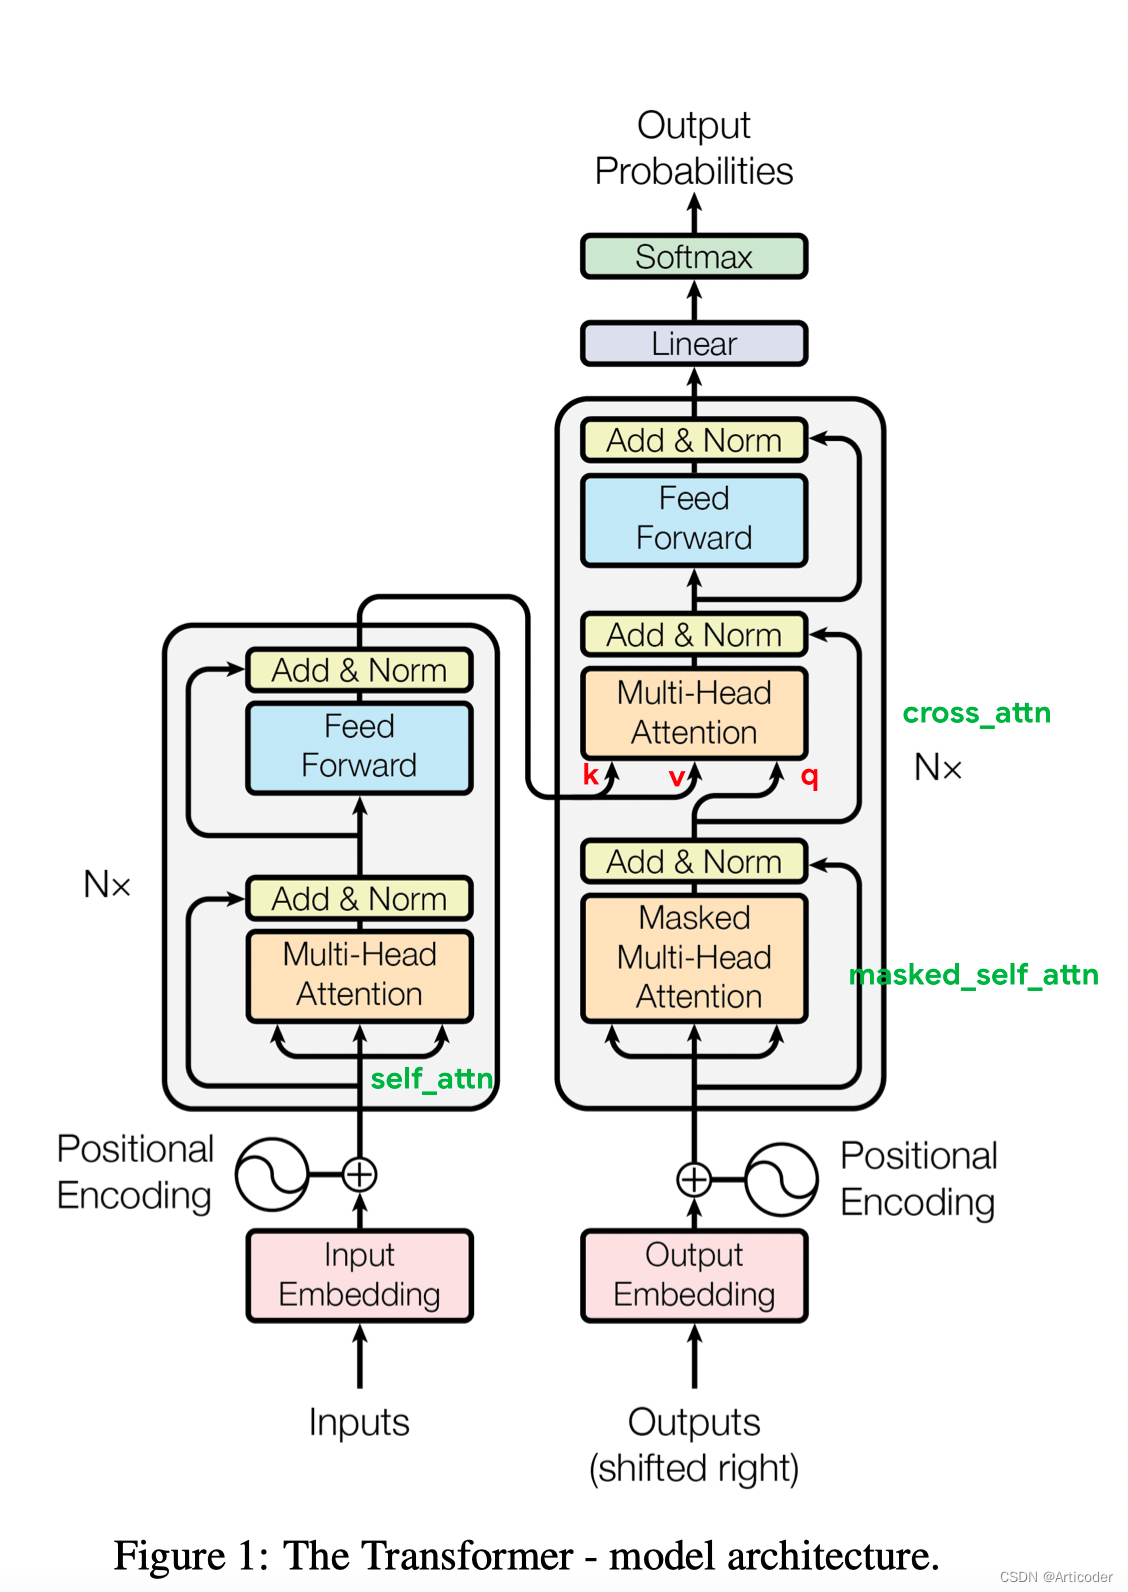

Transformer中有三处需要mask，分别是编码器自注意力、解码器自注意力和解码器交叉注意力，在时间序列中，编码器自注意力和解码器交叉注意力不需要mask，解码器自注意力需要mask，防止未来信息泄露。在NLP中，编码器自注意力和解码器自注意力需要mask，以产生相同序列长度的向量。

### padding mask

一个常见的问题是输入序列长度不等，一般来说我们会对一个 batch 内的向量填充0。

### sequence mask

sequence mask 是为了使得 decoder 不能看见未来的信息。也就是对于一个序列，在 time_step 为 t 的时刻，我们的解码输出应该只能依赖于 t 时刻之前的输出，而不能依赖 t 之后的输出。因此我们需要想一个办法，把 t 之后的信息给隐藏起来。产生一个上三角矩阵，上三角的值全为 1，下三角的值全为 0，对角线也是 0。把这个矩阵作用在每一个序列上，就可以达到我们的目的啦。值得注意的是，本来 mask 只需要二维的矩阵即可，但是考虑到我们的输入序列都是批量的，所以我们要把原本二维的矩阵扩张成 3 维的张量。

TriangularCausalMask类（三角形因果掩码）的主要功能是给每一个batch的序列打上mask，因为输入某一时刻的特征是无法知道未来时刻的特征的。

torch.triu(t, diagonal=1) # 返回主对角线上三角的元素，不包含主对角线上的元素。其余元素为0

In [3]:
import torch
t = torch.randn(3,3)
torch.triu(t, diagonal=1)

tensor([[ 0.0000, -1.2640,  0.3194],
        [ 0.0000,  0.0000,  1.6159],
        [ 0.0000,  0.0000,  0.0000]])

## 注意力机制

### cross_attention

在Transformer中，CrossAttention实际上是指编码器和解码器之间的交叉注意力层。在这一层中，解码器会对编码器的输出进行注意力调整，以获得与当前解码位置相关的编码器信息。在Transformer的编码器-解码器架构中，编码器负责将输入序列编码为一系列特征向量，而解码器则根据这些特征向量逐步生成输出序列。为了使解码器能够对当前生成位置的上下文进行有效的建模，CrossAttention层被引入其中。

解码器的编码-解码注意力层结构与自注意力层也一致，存在query、key和value三个向量。为了更好地建立源语言句子与目标语言句子之间的联系，query来自前一层的解码器，key和value来自编码器的输出。

### self_attention

自注意力层存在于编码器和解码器中，解码器的自注意力层结构与编码器的自注意力层结构一致。解码器中的自注意力层需要添加掩码，防止看到未来的信息，编码器不需要。

# 计算机视觉

## 感受野

- 在卷积神经网络中，感受野(receptive field)不像输出由整个网络输入所决定的全连接网络那样，它是可以存在于网络中任意某层，输出仅由输入部分决定。
- 输出特征层中一个点映射在原始输入图像中的区域。

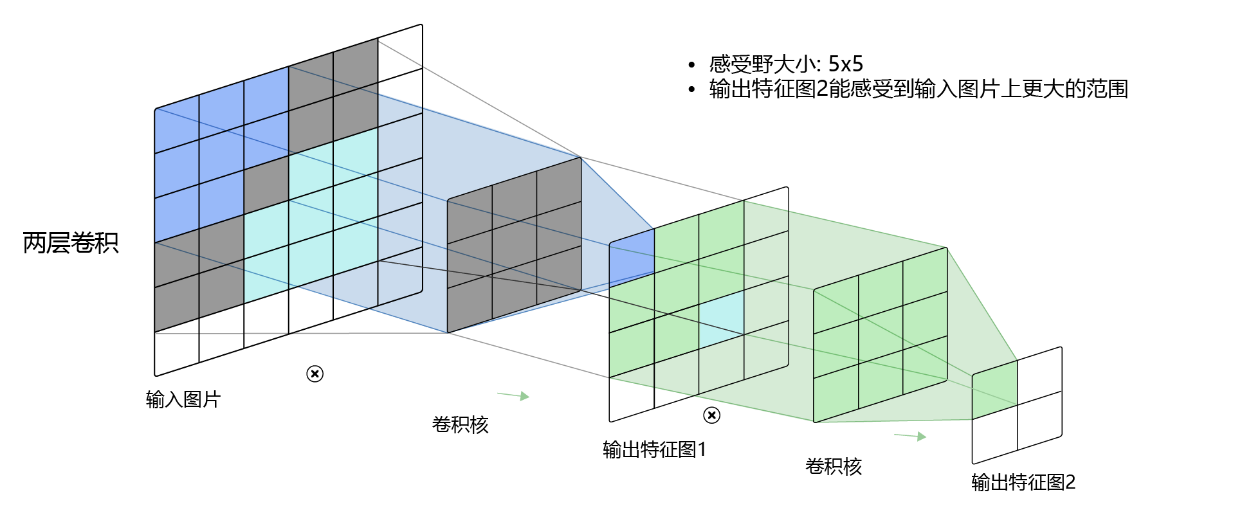

其中，3×3卷积对应的感受野大小就是3×3，而通过两层3×3的卷积之后，感受野的大小将会增加到5×5。

# 代码详解

## model.eval()

在推理时，如果使用model.eval()将不启用 BatchNormalization 和 Dropout，保证BN和dropout不发生变化，pytorch框架会自动把BN和Dropout固定住，不会取平均，而是用训练好的值，不然的话，一旦test的batch_size过小，很容易就会被BN层影响结果。所以在利用原始.pth模型进行前向推理之前，一定要先进行model.eval()操作，不启用 BatchNormalization 和 Dropout。